<a href="https://colab.research.google.com/github/MilesHoyland/CarrotParsnipCNN/blob/main/RootVegClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 40kB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


Other key libraries and modules we need to import are numpy for calculation & and keras for the Neural Network model. The Squential model type is imported along with the Dense & Sequential models from keras.layers. to_categorical is also imported from utilities to convert test data sets into catagorical labels.

In [2]:
# Imports
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

#function for image batching
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#file structure navigation
import os
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import time

In [3]:
# Create images with white backgrounds
import plotly.io as pio
pio.templates.default = 'none'

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import  GoogleCredentials

In [5]:
# Gain authorization for Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Locate dataset
fid = drive.ListFile({'q':"title='DataSet.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('DataSet.zip')

In [7]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [8]:
!unzip DataSet.zip

Archive:  DataSet.zip
   creating: DataSet/
   creating: DataSet/Test/
   creating: DataSet/Test/Carrot/
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse1.mm.bing.net2Fth3Fid3DOIP.ZI_qIbttSKgu0Ef3clDSwHaE826pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.explicit.bing.net2Fth3Fid3DOIP.LqPqi5WnrYJOSAS1rK4ESgHaFY26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.explicit.bing.net2Fth3Fid3DOIP.zB36dxcDIHvKY3B_glpufAHaFj26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.explicit.bing.net2Fth3Fid3DOIP.ZlFMliJQ3Ftd8wkplUYcPwHaLH26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.mm.bing.net2Fth3Fid3DOIP.1O_HzeDRdbG9tk33ZF3bJgHaFw26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.mm.bing.net2Fth3Fid3DOIP.426PG5tZbG6ImNfBl7LD3wHaLL26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3A2F2Ftse2.mm.bing.net2Fth3Fid3DOIP.5JnLwtLkHn4x1mth1rLQHaLG26pid3DApif1.jpg  
  inflating: DataSet/Test/Carrot/uhttps3

# Extracting Data From File

In [9]:
PATH = '/content/DataSet'

In [10]:
os.listdir(PATH)

['Test', 'Train', 'Validate']

## Creating datasets

In [11]:
train_dir = os.path.join(PATH,'Train')
test_dir = os.path.join(PATH, 'Test')
validate_dir = os.path.join(PATH,'Validate')

In [12]:
train_carrot_dir = os.path.join(train_dir, 'Carrot')
train_parsnip_dir = os.path.join(train_dir, 'Parsnip')

test_carrot_dir = os.path.join(test_dir, 'Carrot')
test_parsnip_dir = os.path.join(test_dir, 'Parsnip')

validate_carrot_dir = os.path.join(validate_dir, 'Carrot')
validate_parsnip_dir = os.path.join(validate_dir, 'Parsnip')

### Gather meta data about the directory sizes.


In [14]:
num_carrot_train = len(os.listdir(train_carrot_dir))

In [15]:
num_parsnip_train = len(os.listdir(train_parsnip_dir))

In [16]:
num_carrot_test = len(os.listdir(test_carrot_dir))

In [17]:
num_parsnip_test = len(os.listdir(test_parsnip_dir))

In [18]:
num_carrot_val = len(os.listdir(validate_carrot_dir))

In [19]:
num_parsnip_val = len(os.listdir(validate_parsnip_dir))

In [20]:
print('total training carrot images - ', num_carrot_train)
print('total training parsnip images - ', num_parsnip_train)
print('total validation carrot images - ', num_carrot_val)
print('total validation parnips images - ', num_parsnip_val)
print('total testing carrot images - ', num_carrot_test)
print('total testing parsnip images - ', num_parsnip_test)

total training carrot images -  415
total training parsnip images -  190
total validation carrot images -  100
total validation parnips images -  39
total testing carrot images -  90
total testing parsnip images -  50


# Data Preparation & Augmentation

In [21]:
# Image plotting function
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [22]:
IMG_HEIGHT = 150  
IMG_WIDTH = 150
batch_size = 32

1) Horizontal augmentation on training image gen

In [23]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [24]:
train_data_gen = image_gen.flow_from_directory(batch_size = batch_size, directory = train_dir,shuffle=True ,target_size=(IMG_HEIGHT,IMG_WIDTH), class_mode='binary')

Found 605 images belonging to 2 classes.


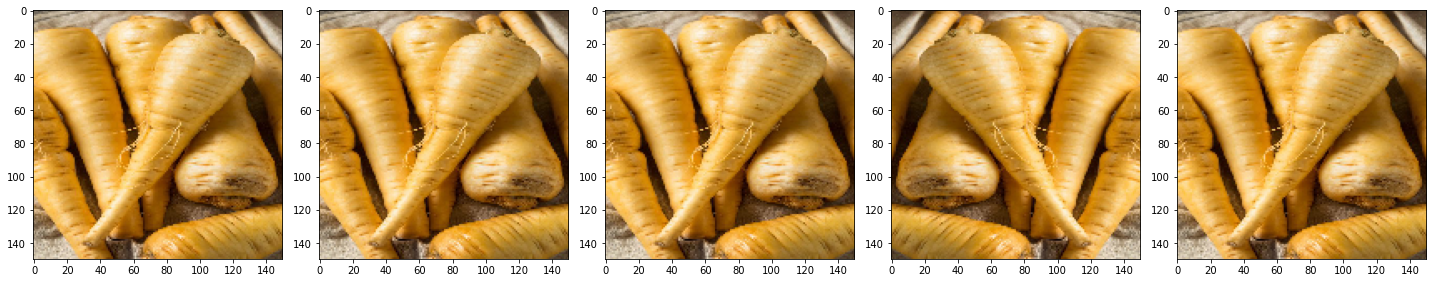

In [25]:
augmentedImages = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmentedImages)

2) Random Rotation for training set

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45,fill_mode='constant')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir,shuffle=True,target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 605 images belonging to 2 classes.


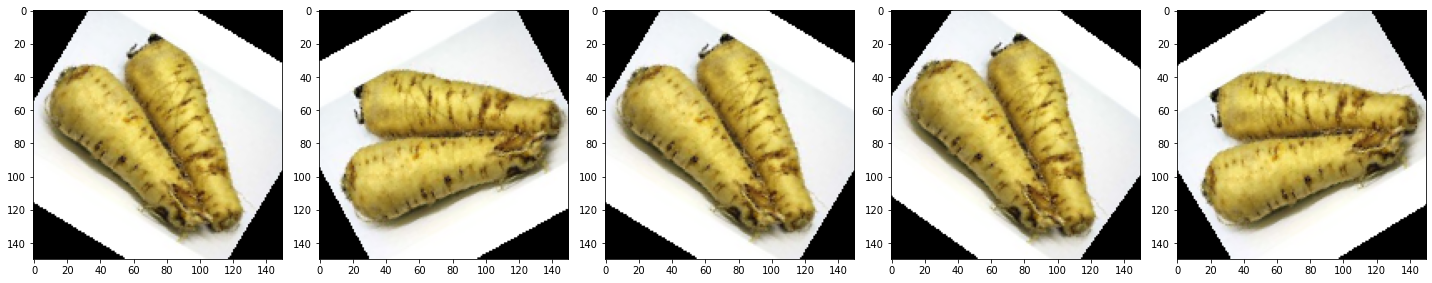

In [27]:
augmentedImages = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmentedImages)

3) Random Zoom for training data

In [28]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir,shuffle=True,target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 605 images belonging to 2 classes.


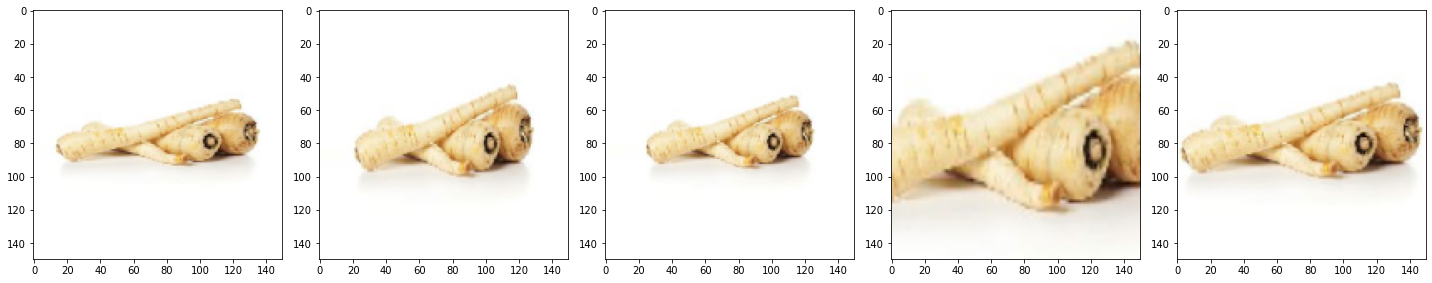

In [29]:
augmentedImages = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmentedImages)

Compiling Augmentations

In [30]:
image_gen_train = ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,directory=train_dir,shuffle=True,target_size=(IMG_HEIGHT,IMG_WIDTH),class_mode='binary')

Found 605 images belonging to 2 classes.


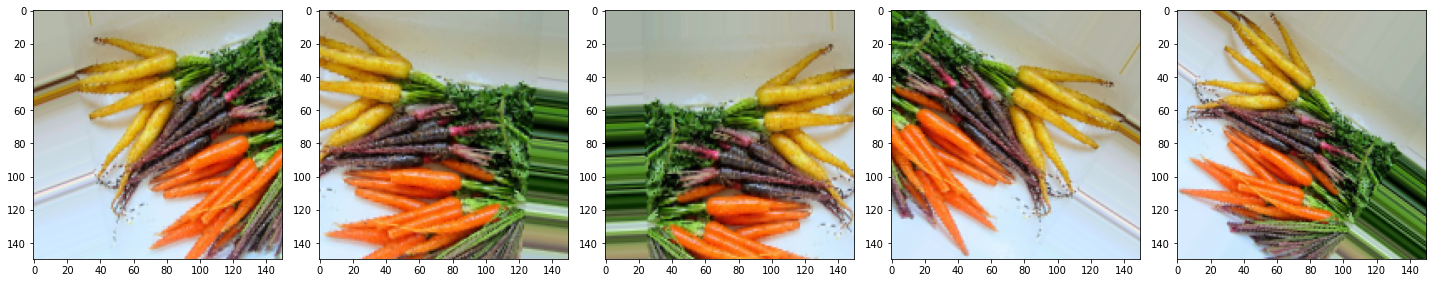

In [31]:
augmentedImages = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmentedImages)

In [32]:
test_data_gen = image_gen.flow_from_directory(directory = test_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), class_mode='binary')

Found 140 images belonging to 2 classes.


In [33]:
image_gen_non_aug = ImageDataGenerator(rescale=1./255)
validate_data_gen = image_gen_non_aug.flow_from_directory(directory=validate_dir, shuffle=False,target_size=(IMG_HEIGHT,IMG_WIDTH), class_mode='binary')

Found 139 images belonging to 2 classes.


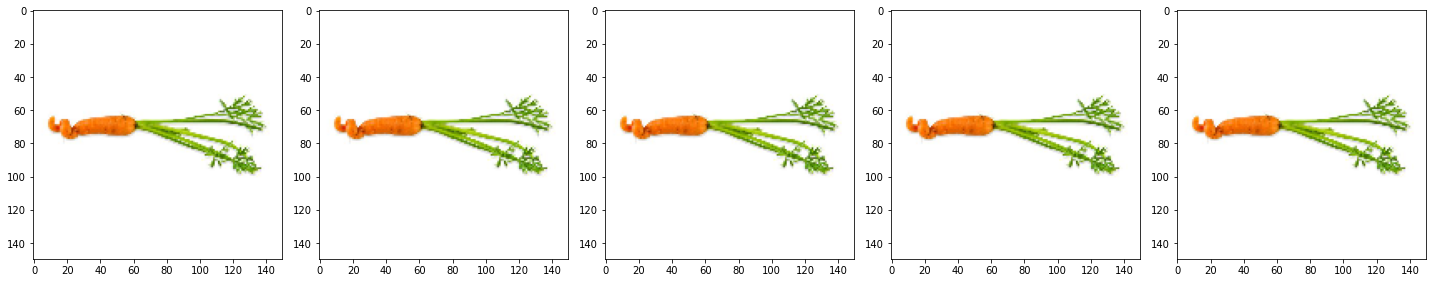

In [34]:
validationImages = [validate_data_gen[0][0][0] for i in range(5)]
plotImages(validationImages)

In [35]:
sample_training_images, _ = next(train_data_gen)

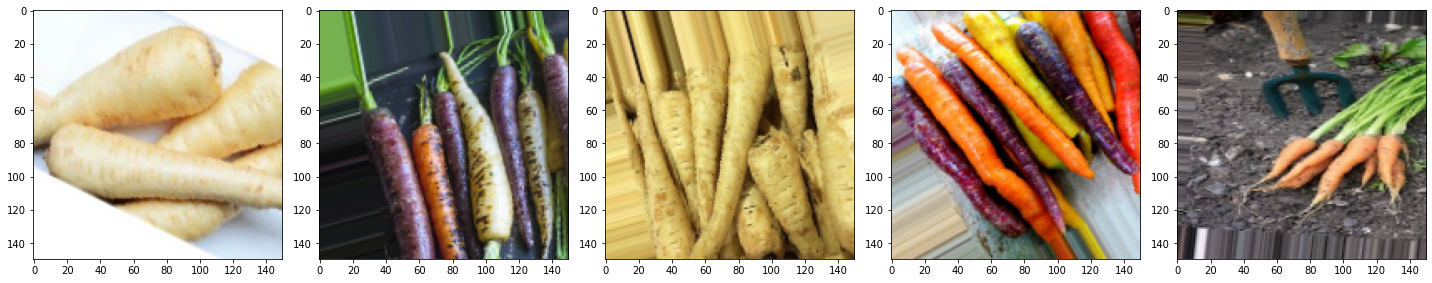

In [36]:
plotImages(sample_training_images[:5]) #plot images 0-4

## Model Definition

In [37]:
model = Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
                    tf.keras.layers.MaxPooling2D(2,2),

                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                    tf.keras.layers.MaxPooling2D(2,2),

                    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                    tf.keras.layers.MaxPooling2D(2,2),
                    
                    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                    tf.keras.layers.MaxPooling2D(2,2),
                    
                    tf.keras.layers.Dropout(0.5),

                    tf.keras.layers.Flatten(),
                    Dense(512,activation='relu'),
                    Dense(2,activation='softmax')
                    ])

### Compile Model

In [38]:
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy', metrics=['accuracy'])

### Model Summary

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [41]:
BATCH_SIZE = 32
EPOCHS = 100

In [42]:
total_train = num_carrot_train + num_parsnip_train
total_val = num_carrot_val + num_parsnip_val
total_test = num_carrot_test + num_parsnip_test

In [43]:
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(total_train/float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              validation_data=validate_data_gen,#test_data_gen,
                              validation_steps=int(np.ceil(total_test/float(BATCH_SIZE)))
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
19/19 [==============================] - 38s 294ms/step - loss: 0.6077 - accuracy: 0.6898 - val_loss: 0.2781 - val_accuracy: 0.9065
Epoch 2/100
19/19 [==============================] - 5s 248ms/step - loss: 0.3812 - accuracy: 0.8161 - val_loss: 0.2193 - val_accuracy: 0.9209
Epoch 3/100
19/19 [==============================] - 5s 249ms/step - loss: 0.3020 - accuracy: 0.8914 - val_loss: 0.1433 - val_accuracy: 0.9353
Epoch 4/100
19/19 [==============================] - 5s 250ms/step - loss: 0.1524 - accuracy: 0.9277 - val_loss: 0.0738 - val_accuracy: 0.9640
Epoch 5/100
19/19 [==============================] - 5s 252ms/step - loss: 0.1286 - accuracy: 0.9494 - val_loss: 0.5858 - val_accuracy: 0.8417
Epoch 6/100
19/19 [==============================] - 5s 248ms/step - loss: 0.2898 - accuracy: 0.8890 - val_loss: 0.1330 - val_accuracy: 0.9424
Epoch 7/100
19/19 [==============================] - 5s 252ms/step - loss: 0.1201 - accuracy: 0.9534 - val_loss: 0.1205 - val_accuracy: 0.971

# Visualizing Results

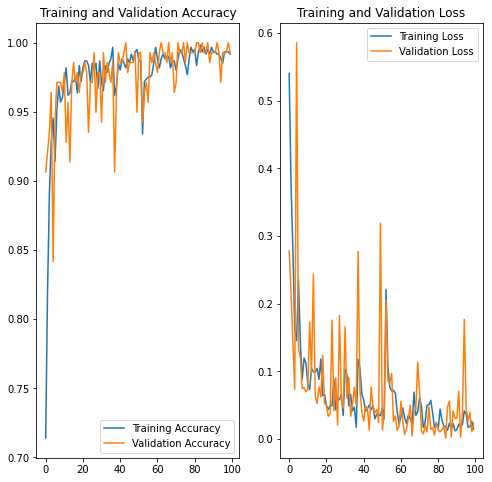

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving Model


In [ ]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras) 

./1616156668.h5


In [ ]:
!ls

1616156252.h5  1616156668.h5  adc.json	DataSet  DataSet.zip  sample_data


In [ ]:
reloaded = tf.keras.models.load_model(export_path_keras)
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

In [ ]:
results_batch = model.predict(test_dir)
reloaded_result_batch = reloaded.predict(test_dir)

IndexError: ignored

In [ ]:
lass_names = np.array(dataset_info.features['label'].names)

print(class_names)
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)